# Multi-parameter calibration of the OpenCL RAMP model using ABC

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the location's hazard rating). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease (?) 

### Parameter calibration
The <ins>location</ins> and <ins>individual</ins> hazards, and the current risk beta rating must be calibrated to find the values which best reproduce real life observations. Here, the parameter values are calibrated once using historical data and Approximate Bayesian Computation (ABC). 

Prior distributions for each parameter are defined and then ABC approximates the likelihoods of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. 

In this script, the predictive model is calibrated once. The model is ran using ABC for 105 days, with two populations.  


### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       


<ins> Other hazards</ins> 
- `current_risk_beta`  

<!-- To adapt an ABM to allow it to be optimised in response to data emerging in real time. This would mean performing dynamic calibration (i.e. re calibrating at every model time step) using ABC. -->

<!-- At the moment, however, such predictive ABMs are generally calibrated once, using historical data to adjust their more flexible parameters such that the model predicts present and past conditions well. The models are then allowed to roll forward in time, independent of the world, to make a prediction. As the systems modelled are usually complex, it is likely that over longer time periods such models diverge from realistic estimates. Even over shorter time periods there is little done to check model performance, let alone constrain it. -->




## Import modules

In [2]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Setup

Read parameters

In [3]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


Open snapshot (i.e. an already-initialised model)

In [4]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

#### Read in observation data

In [5]:
# # Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
cases_devon_daily['Date'] =  pd.to_datetime(cases_devon_daily['Date'])

# # Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

cases_devon_daily.insert(0, 'Day', range(0,len(cases_devon_daily)))
cases_devon_daily = cases_devon_daily.rename(columns ={'OriginalCases': 'Cases'})
cases_devon_daily = cases_devon_daily.drop(['Date', 'Cases'], axis=1)
# cases_devon_daily= cases_devon_daily.rename(columns ={'CumulativeCases': 'Cases'})
cases_devon_daily

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_aggregated_from_daily_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
cases_devon_weekly.head()

,Date,OriginalCases,CumulativeCases
0,2020-03-20,591.126412,591.126412
1,2020-03-27,1271.775267,1862.901679
2,2020-04-03,2012.239343,3875.141022
3,2020-04-10,2527.895824,6403.036845
4,2020-04-17,2584.768611,8987.805457


### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model, i.e. using the parameter values specified in the parameters file

In [6]:
# ### Run default (manually calibrated) model
# This shows what happens with the 'default' (manually calibrated) model
ITERATIONS = 28  # Number of iterations to run for (must be multiple of 7)
NUM_SEED_DAYS =7   # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(iterations = ITERATIONS, repetitions = REPETITIONS, observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR, snapshot_filepath = SNAPSHOT_FILEPATH, 
    num_seed_days = NUM_SEED_DAYS)

In [7]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True, quiet = False)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.27s/it]


In [8]:
best_params = {'retail': 0.5234169902075426, 'primary_school': 0.8189852636000965, 'secondary_school': 1.1516441210574122, 
               'work': 0.07179707294863724, 'presymptomatic': 0.3870375860336805, 'symptomatic': 0.6581503001512558, 
               'asymptomatic': 0.2609686051991401, 'current_risk_beta': 0.01786588871820107}
const_params_dict = {"home": 1.0}
OpenCLRunner.set_constants(const_params_dict)

## Run model with these best parameters
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_mc2, sim_mc2, obs_mc2, out_params_mc2, summaries_mc2) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.86s/it]


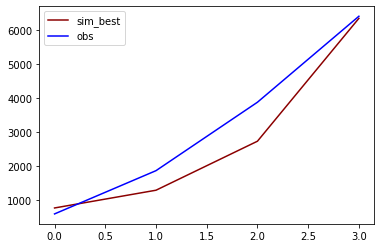

In [9]:
# Check the model returns the observations correctly
# i.e. that theyre the same length
np.array_equal(obs0, cases_devon_daily.loc[:len(sim0)-1,"CumulativeCases"])

# Plot
fig, ax = plt.subplots(1,1)
x = range(len(sim_mc2))
# ax.plot(x, sim0, label="sim", color="orange")
ax.plot(x, sim_mc2, label="sim_best", color="darkred")
ax.plot(x, obs_mc2, label="obs", color="blue")
ax.legend()

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/). Full details in [abc-1.ipynb](abc-1.ipynb)

### Fitness

Need a `distance` function to calculate error. This one gets the observations and simulation data from a dataframe and calls a function that returns the Euclidean distance (L2 norm) calculate 

In [10]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(obs["data"],sim["data"])
    return fit

### Priors

Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


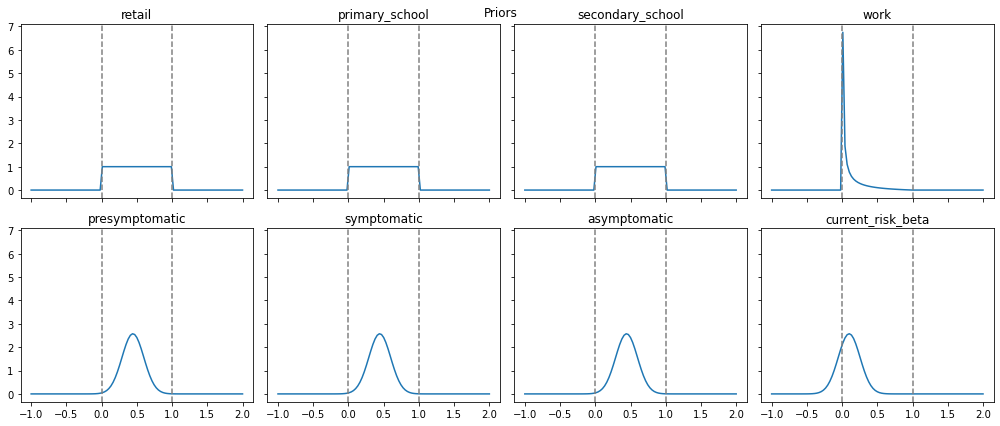

In [11]:
# Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_)
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0 })

# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
# home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([0.03], [1.0])) for _ in range(2) )
current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = { "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv, 
    "current_risk_beta":current_risk_beta_rv}

# Plot prior distributions
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
fig.tight_layout()
fig.suptitle("Priors")
fig.show()

In [12]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution( retail = retail_rv, primary_school = primary_school_rv, secondary_school = secondary_school_rv,
    work = work_rv, presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0), symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0), current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0))

### Initialise the ABC algorithm.

In [13]:
# Create path to database in which to store results
db_path = ("sqlite:///" + os.path.join(".", "InitialModelCalibration.db"))
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler())  # Single core because the model is parallelised
# Define observations to use
y_observed = cases_devon_weekly.loc[:(ITERATIONS/7)-1, "CumulativeCases"].values
# The new method indiciates sarting a new run. It returns a history object, whose id identifies the ABCSMC run in the database. 
# This can be used to load the stored data if we want to continue the run
history = abc.new(db_path, {"data": y_observed}) 
run_id = history.id
print("Run ID:", run_id)

ABC.History INFO: Start <ABCSMC id=17, start_time=2022-03-10 11:48:42>


Run ID: 17


### Run ABC

In [ ]:
history = abc.run(max_nr_populations=1)

ABC INFO: Calibration sample t = -1.


### Resume ABC run

In [149]:
# Create a completely new ABCSMC object. We pass the same model, prior and distance from before.
abc_continued = pyabc.ABCSMC(models=OpenCLRunner.run_model_with_params_abc, parameter_priors=priors,
    distance_function=distance, sampler = pyabc.sampler.SingleCoreSampler()) 
# To resume a run, use the load method to load the necessary data. We pass to this method the id of the run we want to continue
abc_continued.load(db_path, run_id)
# run it
abc_continued.run(max_nr_populations=1)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.09240927e+05.
ABC INFO: Accepted: 100 / 187 = 5.3476e-01, ESS: 1.0000e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=16, duration=1:44:47.040281, end_time=2022-03-10 11:38:41>


In [151]:
history.n_populations

1

#### Save results

In [35]:
fname = "abc-2_105days_7seeddays_v2.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)

### Algorithm diagnostics

In [ ]:
# _, arr_ax = plt.subplots(2, 2)

# pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
# pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
# #pyabc.visualization.plot_credible_intervals(
# #    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
# #    show_mean=True, show_kde_max_1d=True,
# #    refval={'mean': 2.5}, 
# #    arr_ax=arr_ax[1][0])
# pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

# plt.gcf().set_size_inches((12, 8))
# plt.gcf().tight_layout()

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [96]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,primary_school,retail,secondary_school,symptomatic,work,weight
0,440,0.281539,0.035053,0.535545,0.620689,0.176792,0.475518,0.565768,0.000031,0.649376
1,488,0.113824,0.030690,0.515536,0.488512,0.208509,0.829902,0.313837,0.146993,0.143507
2,501,0.667287,0.028755,0.484830,0.190058,0.908964,0.345707,0.522251,0.000842,0.058095
3,484,0.286495,0.038289,0.386109,0.595452,0.072478,0.651968,0.406542,0.013014,0.015240
4,435,0.692552,0.025557,0.426818,0.594824,0.461458,0.944025,0.552833,0.004222,0.012162
...,...,...,...,...,...,...,...,...,...,...
95,465,0.260272,0.034228,0.518310,0.427056,0.881476,0.856182,0.135736,0.165436,0.000038
96,504,0.847555,0.007646,0.603325,0.696242,0.695232,0.689718,0.262696,0.110182,0.000028
97,473,0.064926,0.153532,0.154180,0.668477,0.152824,0.645442,0.416056,0.025189,0.000027
98,476,0.064201,0.041998,0.575648,0.433279,0.960700,0.268226,0.292363,0.110628,0.000024


#### Plot the marginal posteriors  
The estimates of the optimal values for each parameter individually

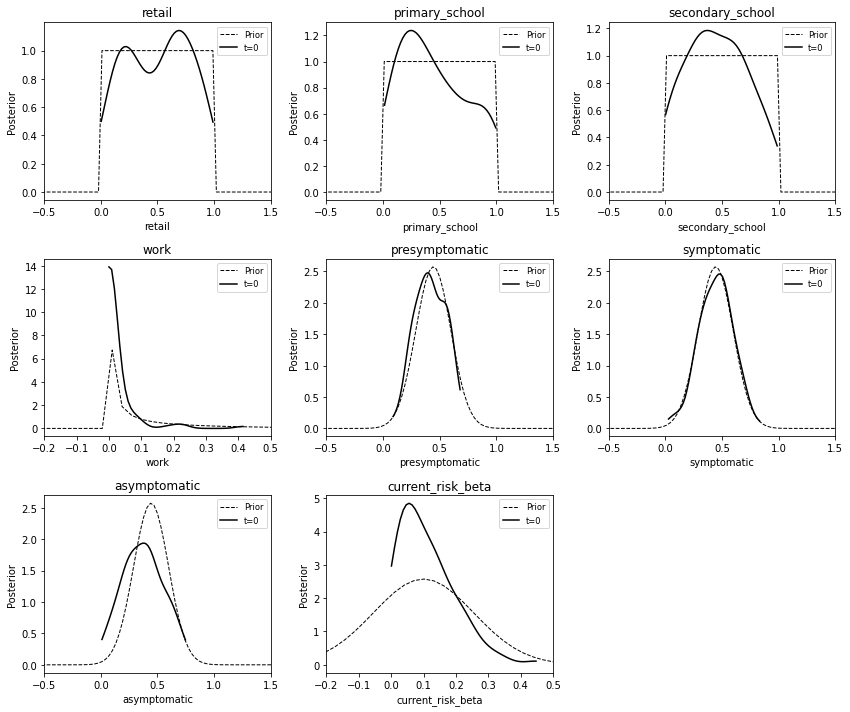

In [150]:
fig, axes = plt.subplots(3,3, figsize=(12,10))
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 5)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    # Add distributions
    for t in range(history.max_t + 1):
        color = colors[t]
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"t={t}", 
            #alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= 'black' if t==history.max_t else color) # Make the last one black
        if param!="work":
            ax.set_xlim(-0.5,1.5)
        if param =='work':
             ax.set_xlim(-0.2,0.5)          
        if param =='current_risk_beta':
             ax.set_xlim(-0.2,0.5)                   
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
axes[2,2].set_axis_off()        
fig.tight_layout()

In [ ]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


In [138]:
# Create dictionary to store results for each window
abc_sum_stats = {}

for t in range(0,history.max_t+1):
    print(t)
    # Create lists to store values for each particle
    data_daily_l = []

    # Get the summary stats for the final population for this window ([1] means keep just the 
    # dataframe and not the array of weights)
    weighted_sum_stats = history.get_weighted_sum_stats_for_model(t=t)[1]

    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats[particle_no]
        # Get daily predictions
        data_daily = particle_x_dict["data_daily"]     
        # Add daily msoa predictions for this particle to list
        data_daily_l.append(data_daily)
    
    abc_sum_stats["t{}".format(t)] = data_daily_l


0
1
2
3
4


In [139]:
weighted_sum_stats = history.get_weighted_sum_stats_for_model(t=2)[1]
weighted_sum_stats[0]

{'data': array([766. , 783.8, 787.6, 788.2]),
 'data_daily': array([101. , 201. , 301. , 402. , 508. , 627. , 766. , 768.8, 771.2,
        774.4, 776.6, 779.6, 781.8, 783.8, 785. , 785.8, 787. , 787.4,
        787.4, 787.4, 787.6, 787.8, 787.8, 787.8, 787.8, 788.2, 788.2,
        788.2])}

In [140]:
abc_sum_stats

{'t0': [array([  101. ,   201. ,   301. ,   402. ,   508. ,   627. ,   766. ,
           862.8,   976. ,  1151. ,  1431. ,  1894.8,  2576.4,  3597.2,
          5082.8,  7073.2,  9406.4, 11829.4, 14310.4, 16757.4, 19224.6,
         21735.4, 24198.8, 26591.8, 28808.6, 30863.8, 32727. , 34517.4]),
  array([  101. ,   201. ,   301. ,   402. ,   508. ,   627. ,   766. ,
           854.6,   967.6,  1126.2,  1357.8,  1716.4,  2219.6,  2967.6,
          4058.6,  5483.6,  7232.4,  9140.8, 10963.4, 12678.6, 14300.8,
         15955. , 17705. , 19610. , 21667.6, 23867.2, 26189.8, 28546.4]),
  array([ 101. ,  201. ,  301. ,  402. ,  508. ,  627. ,  766. ,  773.6,
          784. ,  794.4,  807.4,  821. ,  831.8,  845.8,  861.6,  873.8,
          887.8,  906.2,  924.2,  944.8,  969.6,  991.2, 1019.6, 1045.4,
         1074.8, 1104. , 1133. , 1164. ]),
  array([  101. ,   201. ,   301. ,   402. ,   508. ,   627. ,   766. ,
           954. ,  1178. ,  1524.8,  2136. ,  3136.2,  4729.6,  7031.8,
        

In [118]:
abc_sum_stats['t1'] == abc_sum_stats['t2']

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

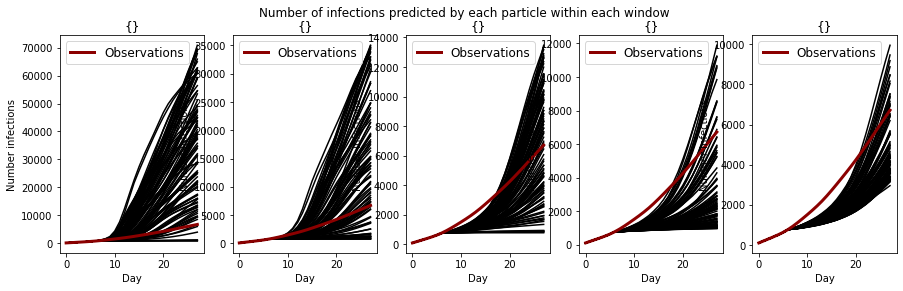

In [143]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Create figure
fig, axes = plt.subplots(1, 5, figsize=(15,4))
axes_number = 0
for t in range(0,history.max_t+1):
        
    data_daily_l = abc_sum_stats["t{}".format(t)]
    
    x = range(0,len(data_daily_l[i])) 
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(data_daily_l)):
        axes[axes_number].plot(x, data_daily_l[i],color="black")  # (1-x because high distance is bad)

    # Add observations
    axes[axes_number].plot(x, initial_cases['CumulativeCases'][0:len(data_daily_l[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    axes[axes_number].set_title("{}")

    # Apply legend
    axes[axes_number].legend(fontsize="large")

    # Set full plot title
    fig.suptitle('Number of infections predicted by each particle within each window')
    
    axes_number =axes_number +1

In [145]:
# Generic functions that are used in the experiments notebooks
# Useful to put them in here so that they can be shared across notebooks
# and can be tested (see tests/experiements/opencl_runner_tests.py)
import os
import numpy as np
import multiprocessing
import itertools
import yaml
import time
import tqdm
import pandas as pd
import random
import datetime
import copy

from typing import List
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.disease_statuses import DiseaseStatus
from microsim.opencl.ramp.summary import Summary
from microsim.opencl.ramp.initial_cases import InitialCases

import matplotlib.pyplot as plt


class OpenCLRunner:
    """Includes useful functions for running the OpenCL model in notebooks"""

    # Need a list to optionally store additional constant parameter values that cannot
    # be passed through one of the run model functions.
    constants = {}

    @classmethod
    def init(cls, iterations: int, repetitions: int, observations: pd.DataFrame, use_gpu: bool,
             use_healthier_pop: bool, store_detailed_counts: bool, parameters_file: str, opencl_dir: str,
             snapshot_filepath: str, num_seed_days: int):
        """
        The class variables determine how the model should run. They need to be class variables
        because the 'run_model_with_params' function, which is called by calibration libraries, can only take
        one parameter argument -- the parameters to calibrate -- not any others. The init() function sets these values.
        :param iterations: Number of iterations to run for
        :param repetitions: Number of repetitions
        :param observations: A dataframe with the observation used to calculate fitness
        :param use_gpu: Whether to use the GPU
        :param store_detailed_counts: Whether to store age-related exposure information
        :param parameters_file:
        :param opencl_dir:
        :param snapshot_filepath:
        :return:
        """
        cls.ITERATIONS = iterations
        cls.REPETITIONS = repetitions
        cls.OBSERVATIONS = observations
        cls.USE_GPU = use_gpu
        cls.USE_HEALTHIER_POP = use_healthier_pop
        cls.STORE_DETAILED_COUNTS = store_detailed_counts
        cls.PARAMETERS_FILE = parameters_file
        cls.OPENCL_DIR = opencl_dir
        cls.SNAPSHOT_FILEPATH = snapshot_filepath
        cls.initialised = True
        cls.NUM_SEED_DAYS = num_seed_days

    @classmethod
    def update(cls, iterations: int = None, repetitions: int = None, observations: pd.DataFrame = None,
               use_gpu: bool = None, use_healthier_pop=None, store_detailed_counts: bool = None,
               parameters_file: str = None,
               opencl_dir: str = None, snapshot_filepath: str = None):
        """
        Update any of the variables that have already been initialised
        """
        if not cls.initialised:
            raise Exception("The OpenCLRunner class needs to be initialised first; call OpenCLRunner.init()")
        if iterations is not None:
            cls.ITERATIONS = iterations
        if repetitions is not None:
            cls.REPETITIONS = repetitions
        if observations is not None:
            cls.OBSERVATIONS = observations
        if use_gpu is not None:
            cls.USE_GPU = use_gpu
        if use_healthier_pop is not None:
            cls.USE_HEALTHIER_POP = use_healthier_pop
        if store_detailed_counts is not None:
            cls.STORE_DETAILED_COUNTS = store_detailed_counts
        if parameters_file is not None:
            cls.PARAMETERS_FILE = parameters_file
        if opencl_dir is not None:
            cls.OPENCL_DIR = opencl_dir
        if snapshot_filepath is not None:
            cls.SNAPSHOT_FILEPATH = snapshot_filepath

    @classmethod
    def set_constants(cls, constants):
        """Set any constant variables (parameters) that override the defaults.
        :param constants: This should be a dist of parameter_nam -> value
        """
        cls.constants = constants

    @classmethod
    def clear_constants(cls):
        cls.constants = {}

    @staticmethod
    def fit_l2(obs: np.ndarray, sim: np.ndarray):
        """Calculate the fitness of a model.

         Parameters
        ----------
        obs : array_like
              The observations data..
        sim : array_like
              The simulated data."""

        if len(obs) != len(sim):
            raise Exception(f"Lengths should be the same, not {len(obs)}) and {len(sim)}")
        if np.array(obs).shape != np.array(sim).shape:
            raise Exception("fShapes should be the same")

        return np.linalg.norm(np.array(obs) - np.array(sim))

    @staticmethod
    def get_mean_total_counts(summaries, disease_status: int, get_sd=False):
        """
        Get the mean total counts for a given disease status at every iteration over a number of model repetitions
        :param summaries: A list of Summary objects created by running the OpenCL model
        :param disease_status: The disease status number, e.g.  `DiseaseStatus.Exposed.value`
        :param get_sd: Optionally get the standard deviation as well
        :return: The mean total counts of the disease status per iteration, or (if get_sd=True)
            or a tuple of (mean,sd)
        """
        reps = len(summaries)  # Number of repetitions
        iters = len(summaries[0].total_counts[disease_status])  # Number of iterations for each repetition
        matrix = np.zeros(shape=(reps, iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[disease_status]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if get_sd:
            return mean, sd
        else:
            return mean

    @staticmethod
    def get_cumulative_new_infections(summaries):
        """
        Get cumulative infections per day by summing all the non-susceptible people
        :param summaries: A list of Summary objects created by running the OpenCL model
        """
        days = len(summaries[0].total_counts[DiseaseStatus.Exposed.value])  # Number of iterations for each repetition
        total_not_susceptible = np.zeros(days)  # Total people not susceptible per iteration
        for d, disease_status in enumerate(DiseaseStatus):
            if disease_status != DiseaseStatus.Susceptible:
                mean = OpenCLRunner.get_mean_total_counts(summaries, d)  # Mean number of people with that disease
                total_not_susceptible = total_not_susceptible + mean
        return total_not_susceptible

    @staticmethod
    def create_parameters(parameters_file: str = None,
                          current_risk_beta: float = None,
                          infection_log_scale: float = None,
                          infection_mode: float = None,
                          presymptomatic: float = None,
                          asymptomatic: float = None,
                          symptomatic: float = None,
                          retail: float = None,
                          primary_school: float = None,
                          secondary_school: float = None,
                          home: float = None,
                          work: float = None,
                          ):
        """Create a params object with the given arguments. This replicates the functionality in
        microsim.main.create_params() but rather than just reading parameters from the parameters
        json file, it allows some of the parameters to be set manually.
        Also note that some (constant) parameters can be set by calling the `set_constants` method.
        This is useful for cases where parameters should override the defaults specified in the
        parameters file but cannot be called directly by the function that is running the model"""

        # Read the default parameters from a yml file, then override with any provided
        if parameters_file is None:
            parameters_file = os.path.join(".", "model_parameters", "default.yml")
        elif not os.path.isfile(parameters_file):
            raise Exception(f"The given parameters file '{parameters_file} is not a file.")

        with open(parameters_file) as f:
            parameters = yaml.load(f, Loader=yaml.SafeLoader)

        sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
        calibration_params = parameters["microsim_calibration"]
        disease_params = parameters["disease"]  # Parameters for the disease model (r)

        # current_risk_beta needs to be set first as the OpenCL model pre-multiplies the hazard multipliers by it
        current_risk_beta = OpenCLRunner._check_if_none("current_risk_beta", current_risk_beta,
                                                        disease_params['current_risk_beta'])

        # Location hazard multipliers can be passed straight through to the LocationHazardMultipliers object.
        # If no argument was passed then the default in the parameters file is used. Note that they need to
        # be multiplied by the current_risk_beta
        location_hazard_multipliers = LocationHazardMultipliers(
            retail=current_risk_beta * OpenCLRunner._check_if_none("retail",
                                                                   retail,
                                                                   calibration_params["hazard_location_multipliers"][
                                                                       "Retail"]),
            primary_school=current_risk_beta * OpenCLRunner._check_if_none("primary_school",
                                                                           primary_school, calibration_params[
                                                                               "hazard_location_multipliers"][
                                                                               "PrimarySchool"]),
            secondary_school=current_risk_beta * OpenCLRunner._check_if_none("secondary_school",
                                                                             secondary_school, calibration_params[
                                                                                 "hazard_location_multipliers"][
                                                                                 "SecondarySchool"]),
            home=current_risk_beta * OpenCLRunner._check_if_none("home",
                                                                 home,
                                                                 calibration_params["hazard_location_multipliers"][
                                                                     "Home"]),
            work=current_risk_beta * OpenCLRunner._check_if_none("work",
                                                                 work,
                                                                 calibration_params["hazard_location_multipliers"][
                                                                     "Work"]),
        )

        # Individual hazard multipliers can be passed straight through
        individual_hazard_multipliers = IndividualHazardMultipliers(
            presymptomatic=OpenCLRunner._check_if_none("presymptomatic",
                                                       presymptomatic,
                                                       calibration_params["hazard_individual_multipliers"][
                                                           "presymptomatic"]),
            asymptomatic=OpenCLRunner._check_if_none("asymptomatic",
                                                     asymptomatic, calibration_params["hazard_individual_multipliers"][
                                                         "asymptomatic"]),
            symptomatic=OpenCLRunner._check_if_none("symptomatic",
                                                    symptomatic,
                                                    calibration_params["hazard_individual_multipliers"]["symptomatic"])
        )

        # Some parameters are set in the default.yml file and can be overridden
        pass  # None here yet

        obesity_multipliers = np.array(
            [disease_params["overweight"], disease_params["obesity_30"], disease_params["obesity_35"],
             disease_params["obesity_40"]])

        cvd = disease_params["cvd"]
        diabetes = disease_params["diabetes"]
        bloodpressure = disease_params["bloodpressure"]
        overweight_sympt_mplier = disease_params["overweight_sympt_mplier"]

        p = Params(
            location_hazard_multipliers=location_hazard_multipliers,
            individual_hazard_multipliers=individual_hazard_multipliers,
        )

        # Remaining parameters are defined within the Params class and have to be manually overridden
        if infection_log_scale is not None:
            p.infection_log_scale = infection_log_scale
        if infection_mode is not None:
            p.infection_mode = infection_mode

        p.obesity_multipliers = obesity_multipliers
        p.cvd_multiplier = cvd
        p.diabetes_multiplier = diabetes
        p.bloodpressure_multiplier = bloodpressure
        p.overweight_sympt_mplier = overweight_sympt_mplier

        return p

    @classmethod
    def _check_if_none(cls, param_name, param_value, default_value):
        """Checks whether the given param is None. If so, it will return a constant value, if it has
         one, or failing that the provided default if it is"""
        if param_value is not None:
            # The value has been provided. Return it, but check a constant hasn't been set as well
            # (it's unlikely that someone would set a constant and then also provide a value for the same parameter)
            if param_name in cls.constants.keys():
                raise Exception(f"A parameter {param_name} has been provided, but it has also been set as a constant")
            return param_value
        else:  # No value provided, return a constant, if there is one, or the default otherwise
            if param_name in cls.constants.keys():
                return cls.constants[param_name]
            else:
                return default_value

    @staticmethod
    def run_opencl_model(i: int, iterations: int, snapshot_filepath: str, params,
                         opencl_dir: str, use_gpu: bool,
                         use_healthier_pop: bool, num_seed_days: int,
                         store_detailed_counts: bool, quiet=bool) -> (np.ndarray, np.ndarray):
        """
        Run the OpenCL model.
        :param i: Simulation number (i.e. if run as part of an ensemble)
        :param iterations: Number of iterations to ru the model for
        :param snapshot_filepath: Location of the snapshot (the model must have already been initialised)
        :param params: a Params object containing the parameters used to define how the model behaves
        :param opencl_dir: Location of the OpenCL code
        :param use_gpu: Whether to use the GPU to process it or not
        :param store_detailed_counts: Whether to store the age distributions for diseases (default True, if
          false then the model runs much more quickly).
        :param quiet: Whether to print a message when the model starts
        :return: A summary python array that contains the results for each iteration and a final state
        """
        # print("opencl_runner.py -- run_opencl_model")
        # load snapshot
        # print(snapshot_filepath)
        snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
        # print(snapshot)
        prev_obesity = np.copy(snapshot.buffers.people_obesity)
        if use_healthier_pop:
            snapshot.switch_to_healthier_population()

        # print("testing obesity arrays not equal")
        # print(np.mean(prev_obesity))
        # print(np.mean(snapshot.buffers.people_obesity))

        # assert not np.array_equal(prev_obesity, snapshot.buffers.people_obesity)
        # print("arrays not equal")

        # set params
        snapshot.update_params(params)

        # set the random seed of the model for each repetition, otherwise it is completely deterministic
        snapshot.seed_prngs(i)

        # Create a simulator and upload the snapshot data to the OpenCL device
        simulator = Simulator(snapshot, opencl_dir=opencl_dir, gpu=use_gpu, num_seed_days=num_seed_days)

        # print(simulator)
        simulator.upload_all(snapshot.buffers)
        # print(simulator.initial_cases)

        # if quiet == False:
        #     print(f"Running simulation {i + 1}.")
        summary, final_state = run_headless(simulator, snapshot, iterations, quiet,
                                            store_detailed_counts=store_detailed_counts)
        return summary, final_state

    #
    # Functions to run the model in multiprocess mode.
    # Don't wory currently on OS X, something to do with calling multiprocessing from a notebook
    # This is a workaround to allow multiprocessing.Pool to work in the pf_experiments_plots notebook.
    # The function called by pool.map ('count_wiggles') needs to be defined in this separate file and imported.
    # https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror/42383397
    #
    @staticmethod
    def run_opencl_model_multi(
            repetitions: int, iterations: int, params: Params, num_seed_days: int, quiet: bool,
            use_gpu: bool = False, use_healthier_pop: bool = False, store_detailed_counts: bool = False,
            opencl_dir=os.path.join(".", "microsim", "opencl"),
            snapshot_filepath=os.path.join(".", "microsim", "opencl", "snapshots", "cache.npz"),
            multiprocess=False,
            random_ids=False):
        """Run a number of models and return a list of summaries.
        :param multiprocess: Whether to run in mutliprocess mode (default False)
        """
        # print("opencl_runner.py - run_opencl_model_multi")
        # Prepare the function arguments. We need one set of arguments per repetition
        l_i = [i for i in range(repetitions)] if not random_ids else \
            [random.randint(1, 100000) for _ in range(repetitions)]
        l_iterations = [iterations] * repetitions
        l_snapshot_filepath = [snapshot_filepath] * repetitions
        l_params = [params] * repetitions
        l_opencl_dir = [opencl_dir] * repetitions
        l_use_gpu = [use_gpu] * repetitions
        l_use_healthier_pop = [use_healthier_pop] * repetitions
        l_num_seed_days = [num_seed_days] * repetitions
        l_store_detailed_counts = [store_detailed_counts] * repetitions
        l_quiet = [quiet] * repetitions  # Whether or not to print info

        args = zip(l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_use_gpu, l_use_healthier_pop,
                   l_num_seed_days, l_store_detailed_counts, l_quiet)
        to_return = None
        start_time = time.time()
        if multiprocess:
            try:
                # i.e. if quiet is false
                if not quiet:
                    print("Running multiple models in multiprocess mode ... ", end="", flush=True)
                with multiprocessing.Pool(processes=int(os.cpu_count())) as pool:
                    to_return = pool.starmap(OpenCLRunner.run_opencl_model, args)
            finally:  # Make sure they get closed (shouldn't be necessary)
                pool.close()
        # i.e. if quiet is true
        else:
            results = itertools.starmap(OpenCLRunner.run_opencl_model, args)
            # Return as a list to force the models to execute (otherwise this is delayed because starmap returns
            # a generator. Also means we can use tqdm to get a progress bar, which is nice.
            if quiet == False:
                to_return = [x for x in tqdm.tqdm(results, desc="Running models", total=repetitions)]
            else:
                to_return = results
        # if quiet == False:
        #     print(f".. finished, took {round(float(time.time() - start_time), 2)}s)", flush=True)
        return to_return

    @classmethod
    def run_model_with_params(cls, input_params: List, return_full_details=False):
        """Run a model REPETITIONS times using the provided parameter values.
        :param input_params: The parameter values to pass, as a list. These need to correspond to specific parameters. Currently they are:
           input_params[0] -> current_risk_beta
        :param return_full_details: If True then rather than just returning the fitness,
            return a tuple of (fitness, summaries_list, final_results_list).
        :return: The mean fitness across all model runs
        """
        if not cls.initialised:
            raise Exception("The OpenCLRunner class needs to be initialised first. "
                            "Call the OpenCLRunner.init() function")

        current_risk_beta = input_params[0]
        infection_log_scale = input_params[1]
        infection_mode = input_params[2]
        presymptomatic = input_params[3]
        asymptomatic = input_params[4]
        symptomatic = input_params[5]

        params = OpenCLRunner.create_parameters(
            parameters_file=cls.PARAMETERS_FILE,
            current_risk_beta=current_risk_beta,
            infection_log_scale=infection_log_scale,
            infection_mode=infection_mode,
            presymptomatic=presymptomatic,
            asymptomatic=asymptomatic,
            symptomatic=symptomatic)

        results = OpenCLRunner.run_opencl_model_multi(
            repetitions=cls.REPETITIONS, iterations=cls.ITERATIONS, params=params, num_seed_days=cls.NUM_SEED_DAYS,
            opencl_dir=cls.OPENCL_DIR, snapshot_filepath=cls.SNAPSHOT_FILEPATH, use_gpu=cls.USE_GPU,
            store_detailed_counts=cls.STORE_DETAILED_COUNTS, multiprocess=False)

        summaries = [x[0] for x in results]
        final_results = [x[1] for x in results]

        # Get the cumulative number of new infections per day
        sim = OpenCLRunner.get_cumulative_new_infections(summaries)
        # Compare these to the observations
        obs = cls.OBSERVATIONS.loc[:cls.ITERATIONS - 1, "Cases"].values
        assert len(sim) == len(obs)
        fitness = OpenCLRunner.fit_l2(obs, sim)
        if return_full_details:
            return fitness, sim, obs, params, summaries
        else:
            return fitness

    @classmethod
    def run_model_with_params_abc(cls, input_params_dict: dict, return_full_details=False, quiet=True):
        """
        Run the model, compatible with pyABC. Random variables (parameters) are passed in as a dictionary.
        For constant parameters that override the defaults (in the default.yml file) set them first
        with the `set_constants` method.
        :param return_full_details: If True then rather than just returning the normal results,
            it returns a tuple of the following:
             (fitness value, simulated results, observations, the Params object, summaries list)
        :param quiet: Turn print messages on (false) or off (true, default)
        :return: The number of cumulative new infections per day (as a list value in a
            dictionary as required by the pyabc package) unless return_full_details is True.
        """
        # print("opencl_runner.py -- run_model_with_params_abc")
        if not cls.initialised:
            raise Exception("The OpenCLRunner class needs to be initialised first. "
                            "Call the OpenCLRunner.init() function")

        # Check that all input parameters are not negative
        for k, v in input_params_dict.items():
            if v < 0:
                raise Exception(f"The parameter {k}={v} < 0. "
                                f"All parameters: {input_params_dict}")

        # Check if there are any constants that should

        # Splat the input_params_dict to automatically set any parameters that have been inlcluded
        params = OpenCLRunner.create_parameters(
            parameters_file=cls.PARAMETERS_FILE,
            **input_params_dict)

        results = OpenCLRunner.run_opencl_model_multi(
            repetitions=cls.REPETITIONS, iterations=cls.ITERATIONS, params=params, num_seed_days=cls.NUM_SEED_DAYS,
            quiet=quiet, opencl_dir=cls.OPENCL_DIR, snapshot_filepath=cls.SNAPSHOT_FILEPATH, use_gpu=cls.USE_GPU,
            store_detailed_counts=cls.STORE_DETAILED_COUNTS, multiprocess=False, random_ids=True)

        summaries = [x[0] for x in results]

        # Get the cumulative number of new infections per day (i.e. simulated results)
        model_daily_cumulative_infections = OpenCLRunner.get_cumulative_new_infections(summaries)
        # Convert from cumulative cases to new cases
        model_daily_new_infections = np.insert(np.diff(model_daily_cumulative_infections), 0,
                                               model_daily_cumulative_infections[0], axis=0)

        # Convert to number of new infections per week (i.e. take sum of each 7 values)
        model_weekly_new_infections = np.add.reduceat(model_daily_new_infections,
                                                      np.arange(0, len(model_daily_new_infections), 7))
        # Convert back to cumulative totals
        model_weekly_cumulative_infections = np.cumsum(model_weekly_new_infections)

        # if not quiet:
        #     print(f"Ran Model with {str(input_params_dict)}")

        # Get observations as array
        obs_weekly_cumulative_infections = cls.OBSERVATIONS.loc[:cls.ITERATIONS - 1, "CumulativeCases"].values
        # Cut to same length as the modelled results
        obs_weekly_cumulative_infections = obs_weekly_cumulative_infections[0:len(model_weekly_cumulative_infections)]
        x=1
        fitness = OpenCLRunner.fit_l2(obs_weekly_cumulative_infections, model_weekly_cumulative_infections)
        if return_full_details:
            # check same length (but obviously will be now as set length based on model)
            assert len(model_weekly_cumulative_infections) == len(obs_weekly_cumulative_infections)
            # Can compare these to the observations to get a fitness
            return fitness, model_weekly_cumulative_infections, obs_weekly_cumulative_infections, params, summaries
        else:  # Return the expected counts in a dictionary
            return {"data": model_weekly_cumulative_infections, "data_daily":model_daily_cumulative_infections,
                    'distance':fitness}


class OpenCLWrapper(object):
    """A simplified version of the OpenCLRunner designed specifically to support using ABC as a day to do
    data assimilation. Uses some features of OpenCLRunner but isn't intended to run a model from start to
    finish."""

    model_counter = 0  # Count the number of models that we run. For debugging mostly

    def __init__(self, const_params_dict,
                 quiet, use_gpu, store_detailed_counts, start_day, run_length,
                 current_particle_pop_df, parameters_file, snapshot_file, opencl_dir,
                 individuals_df, observations_weekly_array, num_seed_days,
                 _random_params_dict=None):
        """The constructor accepts the following:
         - `const_params_dict`: a dictionary of constant model parameters (e.g. hazard coefficients) that are
         not known about by pyabc
         - `current_particle_pop_df`: a dictionary containing the current pyABC population of particles. These
         can be used to re-start previous particles from previous data assimilation windows. If 'None' then
         the model is just starting so there is no previous population.
         - A load of administrative parameters (not used in the model logic).
         - The location of a `parameters_file`, that has default values for parameters (if None then then
         a default location is assumed, see `OpenCLRunner.create_parameters`).
         - The location of the 'snapshot_file' which has the location of a pre-created model snapshot
        Random variables (in `_random_params_dict`) should not be passed directly to the constructor, they should be
        passed via the __call__  function by instantiating an instance of OpenCLWrapper first and then calling that
        object directly. E.g. like this:
        ``m = OpenCLWrapper(const_params_dict={"const_param1":1.0, "const_param2":0.1})
        m(random_variables_dict=={"random_param1":2.0, "random_param2":0.5})``
        That method was suggested here: https://github.com/ICB-DCM/pyABC/issues/446
        """
        # Set administrative parameters
        self.quiet = quiet
        self.use_gpu = use_gpu
        self.store_detailed_counts = store_detailed_counts
        self.start_day = start_day
        self.run_length = run_length
        self.parameters_file = parameters_file
        self.snapshot_file = snapshot_file
        self.opencl_dir = opencl_dir
        self.current_particle_pop_df = current_particle_pop_df
        # The following two are used for calculating model error:
        self.individuals_df = individuals_df
        self.observations_weekly_array = observations_weekly_array
        self.num_seed_days = num_seed_days

        # Now deal with the model parameters
        self.const_params_dict = const_params_dict

        if _random_params_dict is None:  # Only have constant params
            final_params = const_params_dict
        else:  # Have constants *and* random variables
            # Check the parameters are distinct
            for key in const_params_dict:
                if key in _random_params_dict:
                    raise Exception(
                        f"Parameter {key} in the constants dict is also in the random variables dict {_random_params_dict}")
            final_params = {**const_params_dict, **_random_params_dict}

        # Have a single params dict now ('final_params'), can create the Parameters object
        if self.parameters_file is None:
            self.params = OpenCLRunner.create_parameters(**final_params)
        else:
            self.params = OpenCLRunner.create_parameters(parameters_file=self.parameters_file, **final_params)

    def __call__(self, random_params_dict) -> dict:
        """This function is used by pyABC to run the model and pass in random variables.
        :param random_params_dict: Dictionary with random variable values that should be used
        to run the model.
        :return: a dictionary containing model results and other useful pieces of information,
        like the current model state."""

        # Create a new model with previously created constant parameters (set through the constructor)
        # and random variables passed here
        # (Is creation of m actually necessary? Probably not. Advantageous though for when we want
        # to call methods like m.run()

        # print("printing random_params: ", random_params_dict.items())
        for k, v in random_params_dict.items():
            if v < 0:
                raise Exception(f"WRAPPER: The parameter {k}={v} < 0. "
                                f"All parameters: {random_params_dict}")

        m = OpenCLWrapper(const_params_dict=self.const_params_dict,
                          quiet=self.quiet, use_gpu=self.use_gpu, store_detailed_counts=self.store_detailed_counts,
                          start_day=self.start_day, run_length=self.run_length,
                          current_particle_pop_df=self.current_particle_pop_df,
                          parameters_file=self.parameters_file, snapshot_file=self.snapshot_file,
                          opencl_dir=self.opencl_dir,
                          individuals_df=self.individuals_df, observations_weekly_array=self.observations_weekly_array,
                          num_seed_days=self.num_seed_days,
                          _random_params_dict=random_params_dict)
        return m.run()

    @staticmethod
    def summary_stats(raw_model_results: dict) -> dict:
        """Takes raw model results, as output from `__call__` and passed them on to the
        `distance` function. This doesn't actually calculate summary statistics, nor do
        anything else useful in itself, but is useful because anything returned in the
        dictionary is added to the results database, so we can recover a model state, not
        just it's results.
        :param raw_model_results: dictionary of model results as output from __call__.
        :return: processed model results.
        """
        # Check that we receive everything that we expect to
        # print(raw_model_results.keys())
        if "disease_statuses" not in raw_model_results.keys():
            raise Exception(f"No 'disease_statuses' item found in the model results that are passed "
                            f"to summary_stats: {raw_model_results}")

        model_result_summary = raw_model_results['model_result']
        return {"model_summary": model_result_summary, "test": "SUMMARY_TEST"}

        # Just pass the model results on. The 'distance' function can work out how good the results
        # are. The important thing is that the model summary will now be stored by ABC in the database
        # return raw_model_results

    # @staticmethod
    def distance(sim: dict, obs: dict):
        """Calculate the distance between the number of cases in the model by MSOA compared to some observations (case data).
        All lists are assumed to be in the same MSOA order (e.g. first element in each list corresponds to the number of cases
        in the same MSOA).

        :param sim:
        :param obs:
        """

        start_time = datetime.datetime.now()

        # Get the model run length (in days)
        n_days = sim['model_run_length']

        #############################################################################
        # Create dataframe containing the disease status of each individual on each
        # day the model has been ran for, and the area (MSOA) they live in
        # IS THIS CUMULATIVE?
        #############################################################################
        # Get the disease status of each individual on each day in the model run
        cumulative_model_disease_statuses = sim['people_statuses_per_day']

        ## Create dataframe where each row is an individual, and each column contains the number of cases for each individual
        # on a certain day
        # cumulative_model_disease_statuses is a 1D array with the results for each individual on each day stacked on top of each other
        # and so to get the results for each day, need to split off each 695,309 results and add to new column
        cumulative_model_disease_statuses_df = pd.DataFrame()
        colnames = []
        for i in range(1, n_days + 1):
            colnames.append('Day' + str(i))
            df = pd.DataFrame(cumulative_model_disease_statuses[(695309 * (i - 1)):(695309 * i)])
            cumulative_model_disease_statuses_df = pd.concat([cumulative_model_disease_statuses_df, df], axis=1)
        cumulative_model_disease_statuses_df.columns = colnames

        ###### Load dataframe containing info on all individuals
        individuals_df = obs['individuals']
        # Keep just column with the MSOA area code each individual lives in
        individuals_df = individuals_df[['area']]

        # Join DF containing disease status of each individual on each day to the DF containing info on each individual
        # including which MSOA they are found within
        cumulative_model_disease_statuses_df = pd.concat([cumulative_model_disease_statuses_df, individuals_df], axis=1)

        ########################################################################
        ########################################################################
        # Get the number of individuals in disease states 1-4 for each area (MSOA)
        # for each day the model is run for
        ########################################################################
        ########################################################################
        #### Find the total number of people in a disease status for each MSOA on each day
        # Create empty dataframe to population
        cumulative_model_diseased_by_area = pd.DataFrame()
        # Loop through each day...
        for i in range(1, n_days + 1):
            day = 'Day' + str(i)
            # Find the total number of individuals in each disease status on this day
            cumulative_model_disease_statuses_by_area = (
                pd.crosstab([cumulative_model_disease_statuses_df.area], cumulative_model_disease_statuses_df[day]))
            # Add a column with the total number in any of the disease states
            # list the disease status columns to include
            columns_in_df = list(cumulative_model_disease_statuses_by_area.columns.values)
            columns_to_include = [i for i in [1.0, 2.0, 3.0, 4.0] if i in columns_in_df]
            # Filter out columns we don't want to include
            cumulative_model_disease_statuses_by_area[day] = cumulative_model_disease_statuses_by_area[
                columns_to_include].sum(axis=1)
            # Add this to the dataframe to store results in
            cumulative_model_diseased_by_area = pd.concat(
                [cumulative_model_diseased_by_area, cumulative_model_disease_statuses_by_area[day]], axis=1)
        # Add a column containing the cumulative total over all the days
        cumulative_model_diseased_by_area['CumulativeTotal_model'] = cumulative_model_diseased_by_area.sum(axis=1)

        ########################################################################
        ########################################################################
        # Create dataframe containing the observed number of cases on each day
        ########################################################################
        ########################################################################
        # Get the observations
        observations = obs['observation']
        # Create as dataframe
        observations_df = pd.DataFrame(data=observations[0:, 0:], index=cumulative_model_diseased_by_area.index,
                                       columns=['Week' + str(i) for i in range(1, observations.shape[1] + 1)])
        # Add a cumulative total of cases from the first X days
        n_weeks = int(n_days / 7)
        observations_df['CumulativeTotal_obs'] = observations_df.iloc[:, 0:n_weeks].sum(axis=1)

        ########################################################################
        ########################################################################
        # Find euclidean difference between cumulative number of cases over the
        # number of days being considered
        ########################################################################
        ########################################################################
        ## Join model with obs
        obs_and_model_df = pd.concat(
            [observations_df['CumulativeTotal_obs'], cumulative_model_diseased_by_area['CumulativeTotal_model']],
            axis=1)
        obs_and_model_df.loc['Total'] = obs_and_model_df.sum()
        obs_and_model_df = obs_and_model_df.iloc[-1:]

        # Find the euclidean difference between the cumulative cases in model and obs
        difference = np.linalg.norm(
            np.array(obs_and_model_df['CumulativeTotal_obs']) - np.array(obs_and_model_df['CumulativeTotal_model']))

        # print("Found distance in {}".format(datetime.datetime.now() - start_time))
        return {"difference": difference,
                "cumulative_model_diseased_by_area": cumulative_model_diseased_by_area}

    @staticmethod
    def dummy_distance(sim: dict, obs: dict):
        """PyABC needs a function that takes model results (`sim`) and some observations (`obs`) and returns the
        error (the 'distance' between the model results and the observations. This calculation is performed
        by the OpenCLWrapper.distance() function. But the calculation is done as part of the model run() and
        then included in the results returned by the model. THerefore all this function needs to do is pass that
        distance on to PyABC"""
        return sim["distance"]

    def run(self):
        # store start time in order to store run time
        start_time = datetime.datetime.now()

        # Count how many times the model is run. This isn't an ID, but can be useful for debugging
        OpenCLWrapper.model_counter += 1
        model_number = OpenCLWrapper.model_counter
        # Print progress statement
        # print(f"OpenclRunner is running model {model_number}")

        # If this is the first data assimilation window, we can just run the model as normal
        if self.start_day == 0:
            assert self.current_particle_pop_df is None  # Shouldn't have any previously-created particles
            # load snapshot
            snapshot = Snapshot.load_full_snapshot(path=self.snapshot_file)
            # set params
            snapshot.update_params(self.params)
            # Can set the random seed to make it deterministic (None means np will choose one randomly)
            snapshot.seed_prngs(seed=None)
            # Create a simulator and upload the snapshot data to the OpenCL device
            simulator = Simulator(snapshot, num_seed_days=self.num_seed_days, opencl_dir=self.opencl_dir,
                                  gpu=self.use_gpu)
            simulator.upload_all(snapshot.buffers)
            # if quiet == False:
            # print(f"Running simulation {sim_number + 1}.")
            # print(f"Running simulation")

            params = Params.fromarray(snapshot.buffers.params)  # XX Why extract Params? Can't just use PARAMS?
            summary = Summary(snapshot,store_detailed_counts=self.store_detailed_counts,max_time=self.run_length)  # Total length of the simulation

            # only show progress bar in quiet mode
            timestep_iterator = range(self.run_length)
            # if self.quiet:
            #     timestep_iterator = range(self.run_length)
            # else :
            #     else tqdm(range(self.quiet), desc="Running simulation")

            # timestep_iterator = range(self.run_length) if self.quiet \
            #     else tqdm(range(self.quiet), desc="Running simulation")

            # Create array to store the disease statuses for each day
            people_statuses_per_day = np.array([], dtype='uint8')
            iter_count = 0  # Count the total number of iterations
            # Run for iterations days
            for _ in timestep_iterator:
                # Update parameters based on lockdown
                params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
                simulator.upload("params", params.asarray())
                params.asarray()
                # Step the simulator
                simulator.step()
                iter_count += 1

                # Download today's data
                simulator.download("people_statuses", snapshot.buffers.people_statuses)
                # Save the people's statuses
                people_statuses_per_day = np.append(people_statuses_per_day, snapshot.buffers.people_statuses, axis=0)

                # Download the statuses at the end of the window (no need to do this now as we do it at the end of the for loop)
                # simulator.download("people_statuses", snapshot.buffers.people_statuses)
                # Update the summary with this new data
                summary.update(iter_count, snapshot.buffers.people_statuses)

            # print(len(people_statuses_per_day))
            if self.quiet == False:
                for i in range(self.run_length):
                    print(f"\nDay {i}")
                    summary.print_counts(i)

            if self.quiet == False:
                print("\nFinished")

            # Download the snapshot from OpenCL to host memory
            # XX This is 'None'.
            final_state = simulator.download_all(snapshot.buffers)

            pass
        else:  # Otherwise we need to restart previous models stored in the current_particle_pop_df
            # XXXX CAN GET OLD MODEL STATES, WITH ALL DISEASE STATUSES, FROM THE DF. TWO ISSUES
            # 1. But need to work out how to draw these appropriately; can't assume they are each as good as
            # each other. THIS SHOULD BE OK, surely there's a way to go from the final particles and weights
            # to the DF of state vectors. Particle ID? Just try it out.
            # 2. Also: what to do about stochasticity. For a given (global) parameter combination, we will
            # get quite different results depending on the mode state. - I DON'T THINK THIS IS A PROBLEM.
            # ABC Commonly used with stochastic models. E.g. https://eprints.lancs.ac.uk/id/eprint/80439/1/mainR1.pdf
            #
            raise Exception("Not implemented yet")

        x =1
        sim = OpenCLRunner.get_cumulative_new_infections([summary])

        # Return any useful information from the model.
        # print("OpenclRunner ran model {} in {}".format(model_number, datetime.datetime.now() - start_time))

        # Could return the disease statuses (not currently needed)
        # disease_statuses = snapshot.buffers.people_statuses.copy()

        # Calculate the error ('distance') and include that in the information returned
        observations = self.observations_weekly_array
        if model_number == 1:
            print("Current_risk_beta is: ", self.const_params_dict['current_risk_beta'])

        dist = OpenCLWrapper.distance(
            sim={'model_run_length': self.run_length, 'people_statuses_per_day': people_statuses_per_day},
            obs={'individuals': self.individuals_df, "observation": self.observations_weekly_array})

        return {"distance": dist['difference'], "model_number": model_number,
                "model_run_length": self.run_length,
                "cumulative_model_diseased_by_area": dist['cumulative_model_diseased_by_area']}

### Find the optimal model
Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:
 1. Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.
 2. Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).



#### 1. Sample from posterior using ABC 
Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.
 - For each of the 100 particles in the final population of the model, get the associated weight and value for each parameter
 - Estimate the underlying distribution from which these particles were drawn using KDE
 - Sample X times from this distribution

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [42]:
# Define number of samples
N_samples = 100
# Retrieve information on parameter posteriors
# This returns a dataframe containing the values associated with each parameter for each of the 100 particles
# in the last availalbe population of model m. Also an array of weights associated with each particle.
df, w = history.get_distribution(m=0, t=history.max_t)

# Fit a KDE to the posterior to allow new parameters to be proposed based on the current population
# Use KDE to estimate the underlying probability distribution that generated the datasets df, w
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
# Take X samples from this new distribution
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
#         print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    param_values = {param: sample[str(param)] for param in priors}

    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
#     print(f"Fitness: {_fitness}.")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")
    
# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])
    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Fitness: 5120.191256353875.
Fitness: 1431.960500873513.
Found negatives. Resampling
Fitness: 1921.6672489198031.
Fitness: 3196.8984759188097.
Fitness: 1323.0094542039965.
Fitness: 4425.659633628913.
Found negatives. Resampling
Found negatives. Resampling
Fitness: 2348.5033849810056.
Found negatives. Resampling
Fitness: 4155.713090046403.
Fitness: 3406.2312664333776.
Fitness: 3341.7902641002597.
Fitness: 2107.545020541802.
Fitness: 1432.008872889555.
Fitness: 1239.8126025614872.
Fitness: 1820.0857568600309.
Fitness: 2082.5955103589054.
Found negatives. Resampling
Fitness: 1334.4416713975704.
Found negatives. Resampling
Fitness: 3118.3509858904617.
Fitness: 2700.9198850310586.
Fitness: 3174.3288401159975.
Fitness: 3244.2702677655734.
Fitness: 1940.1448295401099.
Fitness: 2285.572844031306.
Fitness: 1665.0704432735345.
Fitness: 3409.4799190040344.
Fitness: 2285.330431280441.
Found negatives. Resampling
Fitness: 2455.9993513414397.
Fitness: 1906.6790041756717.
Fitness: 3099.1783488011174.


#### Plot each sample's predicted infections 
The darker the line, the higher the fitness of the sample

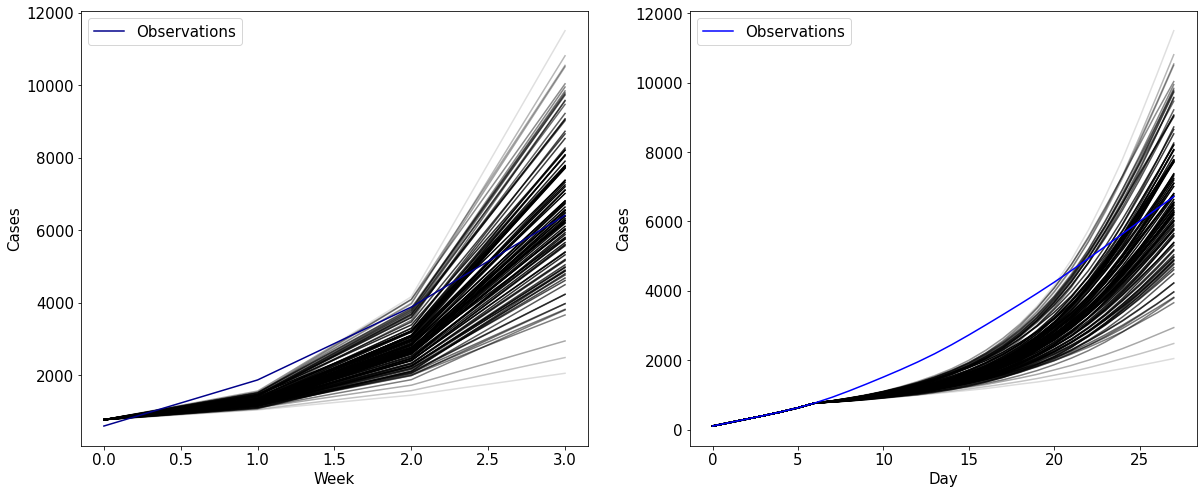

In [48]:
# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - fitness_norm[i])  # (1-x because high fitness is bad)
# Plot observations
ax1.plot(x, obs_l[0], label="Observations", color="darkblue")
# Plot result from manually calibrated model
# ax1.plot(x, sim0, label="Initial sim", color="orange")
# Format
ax1.legend(fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)
# ax1.set_ylim(0,90000)

############## PLOT DAILY DATA 
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            color="black", alpha=1 - fitness_norm[i])  # (1-x because high fitness is bad)
# Plot observations
ax2.plot(x, cases_devon_daily['CumulativeCases'][0:ITERATIONS], label="Observations", color="blue")
# # Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)
# ax2.set_ylim(0,90000)
plt.show()

del _fitness, fitness_norm


Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

In [ ]:
# # Weekly

# #best_paramswo long arrays with every result from every particle
# x = list(range(len(sim_l[0])))  # List of iteration numbers (i.e week numbers)
# X = []
# for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
#     X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
# X = np.array(X)
# y = []
# for i in range(len(summaries_l)):
#     y += list(sim_l[i])
# y = np.array(y)

# # Generate the GAM
# gam = LinearGAM( n_splines=250)
# #gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
# gam.gridsearch(X, y)
# #XX = gam.generate_X_grid(term=0, n=len(X))
# XX = gam.generate_X_grid(term=0)

# # Plot
# fig, ax = plt.subplots(1,1, figsize=(12,8))

# ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
# ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

# #pdep, confi = gam.partial_dependence(term=0, width=.95)
# #ax.plot(XX, pdep)
# #ax.plot(XX, confi, c='r', ls='--')

# ax.plot(x, obs_l[0], label="Observations", color="blue")
# ax.plot(x, sim0, label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('95% prediction interval');


# # ## Daily??

# # #best_paramswo long arrays with every result from every particle
# # x = list(range(len(sim_l[0])*7))  # List of iteration numbers (i.e week numbers)
# # X = []
# # for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
# #     X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
# # X = np.array(X)
# # y = []
# # for i in range(len(summaries_l)):
# #     y +=  list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
# # y = np.array(y)

# # # Generate the GAM
# # gam = LinearGAM( n_splines=250)
# # #gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
# # gam.gridsearch(X, y)
# # #XX = gam.generate_X_grid(term=0, n=len(X))
# # XX = gam.generate_X_grid(term=0)


# # # Plot
# # fig, ax = plt.subplots(1,1, figsize=(12,8))

# # ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
# # ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

# # #pdep, confi = gam.partial_dependence(term=0, width=.95)
# # #ax.plot(XX, pdep)
# # #ax.plot(XX, confi, c='r', ls='--')

# # ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
# # ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.legend()
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.set_title('95% prediction interval');



Do a KDE plot with a logarithmic colour scale.

In [49]:
# # # Do a KDE plot with a logarithmic colour scale.
# # from matplotlib.colors import LogNorm
# # fig, ax = plt.subplots(1,1, figsize=(10,7))
# # h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
# # ax.set_xlabel("Iteration")
# # ax.set_ylabel("Cumulative cases")

# # ax.plot(x, obs_l[0], label="Observations", color="blue")
# # ax.plot(x, sim0, label="Initial sim", color="orange")
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.legend()
# # fig.colorbar(h[3], ax=ax)
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.set_title('Density plot of results posterior');

# #Do a KDE plot with a logarithmic colour scale.
# from matplotlib.colors import LogNorm
# fig, ax = plt.subplots(1,1, figsize=(10,7))
# h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
# ax.set_xlabel("Iteration")
# ax.set_ylabel("Cumulative cases")

# ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
# ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# fig.colorbar(h[3], ax=ax)
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('Density plot of results posterior');

#### 2. Find the parameter modes

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [50]:
####### Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
print(best_params)

{'retail': 0.5234169902075426, 'primary_school': 0.8189852636000965, 'secondary_school': 1.1516441210574122, 'work': 0.07179707294863724, 'presymptomatic': 0.3870375860336805, 'symptomatic': 0.6581503001512558, 'asymptomatic': 0.2609686051991401, 'current_risk_beta': 0.01786588871820107}


See how those parameters relate to the marginal posteriors

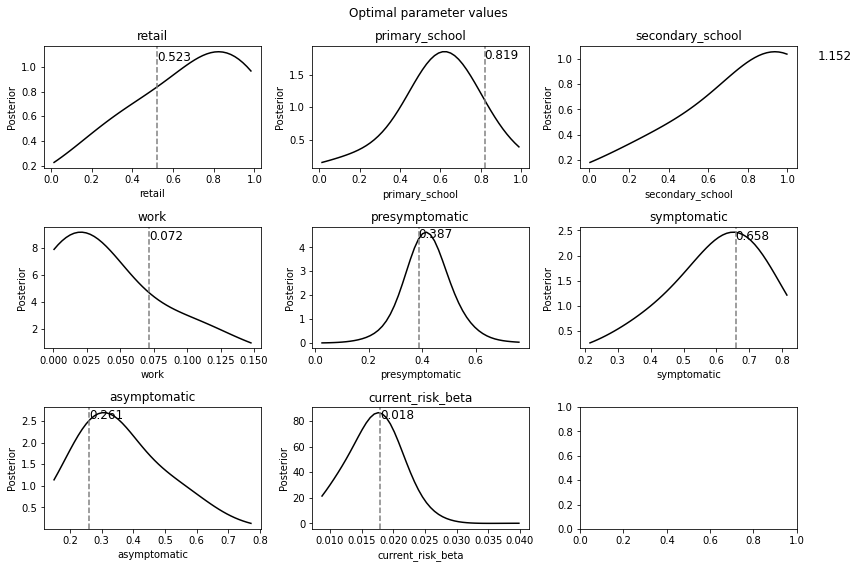

In [51]:
######## See how those parameters relate to the marginal posteriors
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))
fig, axes = plt.subplots(3,3, figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    #ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

In [59]:
# best params1
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_bp, sim_bp, obs_bp, out_params_bp, summaries_bp) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.81s/it]


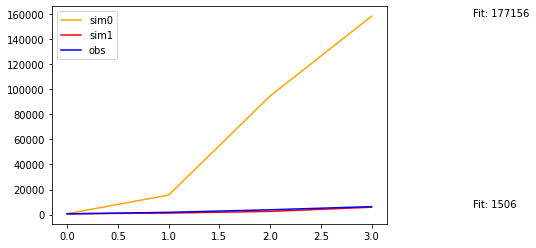

In [58]:
# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs_bp)

fig, ax = plt.subplots(1,1)
x = range(len(sim_bp))
ax.plot(x, sim0, label="sim0", color="orange")
ax.plot(x, sim_bp, label="sim1", color="red")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries_bp, fitness_bp)]:
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs_bp, label="obs", color="blue")
ax.legend()

Run the model with arbitray parameters (to experiment)

Fitness: 1334.2324958675463


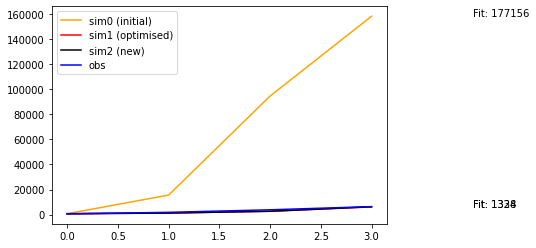

In [60]:
#OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness2, sim2, obs2, out_params2, summaries2) = OpenCLRunner.run_model_with_params_abc(
    {'retail': 0.9,
     'primary_school': 0.9,
     'secondary_school': 0.9,
     'work': 0.00001,
     'asymptomatic': 0.124},
    return_full_details=True)
#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

fig, ax = plt.subplots(1,1)
x = range(len(sim_bp))
ax.plot(x, sim0, label="sim0 (initial)", color="orange")
ax.plot(x, sim_bp, label="sim1 (optimised)", color="red")
ax.plot(x, sim2, label="sim2 (new)", color="black")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries_bp, fitness_bp), (summaries2, fitness2) ]:
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs_bp, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness_bp}")


## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

In [131]:
# Function to plot disease status by MSOA for a given timestep and status
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

## Load required data
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
gis_data_dir = ("../../devon_data")
osm_buildings = load_osm_shapefile(gis_data_dir)
devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)    
    

N=len(summaries_bp)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries_bp[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


NameError: name 'summaries_bp' is not defined

In [ ]:
# Generic functions that are used in the experiments notebooks
# Useful to put them in here so that they can be shared across notebooks
# and can be tested (see tests/experiements/opencl_runner_tests.py)
import os
import numpy as np
import multiprocessing
import itertools
import yaml
import time
import tqdm
import pandas as pd
import random
import datetime
import copy

from typing import List
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.disease_statuses import DiseaseStatus
from microsim.opencl.ramp.summary import Summary
from microsim.opencl.ramp.initial_cases import InitialCases

import matplotlib.pyplot as plt


class OpenCLRunner:
    """Includes useful functions for running the OpenCL model in notebooks"""

    # Need a list to optionally store additional constant parameter values that cannot
    # be passed through one of the run model functions.
    constants = {}

    @classmethod
    def init(cls, iterations: int, repetitions: int, observations: pd.DataFrame, use_gpu: bool,
             use_healthier_pop: bool, store_detailed_counts: bool, parameters_file: str, opencl_dir: str,
             snapshot_filepath: str, num_seed_days: int):
        """
        The class variables determine how the model should run. They need to be class variables
        because the 'run_model_with_params' function, which is called by calibration libraries, can only take
        one parameter argument -- the parameters to calibrate -- not any others. The init() function sets these values.
        :param iterations: Number of iterations to run for
        :param repetitions: Number of repetitions
        :param observations: A dataframe with the observation used to calculate fitness
        :param use_gpu: Whether to use the GPU
        :param store_detailed_counts: Whether to store age-related exposure information
        :param parameters_file:
        :param opencl_dir:
        :param snapshot_filepath:
        :return:
        """
        cls.ITERATIONS = iterations
        cls.REPETITIONS = repetitions
        cls.OBSERVATIONS = observations
        cls.USE_GPU = use_gpu
        cls.USE_HEALTHIER_POP = use_healthier_pop
        cls.STORE_DETAILED_COUNTS = store_detailed_counts
        cls.PARAMETERS_FILE = parameters_file
        cls.OPENCL_DIR = opencl_dir
        cls.SNAPSHOT_FILEPATH = snapshot_filepath
        cls.initialised = True
        cls.NUM_SEED_DAYS = num_seed_days

    @classmethod
    def update(cls, iterations: int = None, repetitions: int = None, observations: pd.DataFrame = None,
               use_gpu: bool = None, use_healthier_pop=None, store_detailed_counts: bool = None,
               parameters_file: str = None,
               opencl_dir: str = None, snapshot_filepath: str = None):
        """
        Update any of the variables that have already been initialised
        """
        if not cls.initialised:
            raise Exception("The OpenCLRunner class needs to be initialised first; call OpenCLRunner.init()")
        if iterations is not None:
            cls.ITERATIONS = iterations
        if repetitions is not None:
            cls.REPETITIONS = repetitions
        if observations is not None:
            cls.OBSERVATIONS = observations
        if use_gpu is not None:
            cls.USE_GPU = use_gpu
        if use_healthier_pop is not None:
            cls.USE_HEALTHIER_POP = use_healthier_pop
        if store_detailed_counts is not None:
            cls.STORE_DETAILED_COUNTS = store_detailed_counts
        if parameters_file is not None:
            cls.PARAMETERS_FILE = parameters_file
        if opencl_dir is not None:
            cls.OPENCL_DIR = opencl_dir
        if snapshot_filepath is not None:
            cls.SNAPSHOT_FILEPATH = snapshot_filepath

    @classmethod
    def set_constants(cls, constants):
        """Set any constant variables (parameters) that override the defaults.
        :param constants: This should be a dist of parameter_nam -> value
        """
        cls.constants = constants

    @classmethod
    def clear_constants(cls):
        cls.constants = {}

    @staticmethod
    def fit_l2(obs: np.ndarray, sim: np.ndarray):
        """Calculate the fitness of a model.

         Parameters
        ----------
        obs : array_like
              The observations data..
        sim : array_like
              The simulated data."""

        if len(obs) != len(sim):
            raise Exception(f"Lengths should be the same, not {len(obs)}) and {len(sim)}")
        if np.array(obs).shape != np.array(sim).shape:
            raise Exception("fShapes should be the same")

        return np.linalg.norm(np.array(obs) - np.array(sim))

    @staticmethod
    def get_mean_total_counts(summaries, disease_status: int, get_sd=False):
        """
        Get the mean total counts for a given disease status at every iteration over a number of model repetitions
        :param summaries: A list of Summary objects created by running the OpenCL model
        :param disease_status: The disease status number, e.g.  `DiseaseStatus.Exposed.value`
        :param get_sd: Optionally get the standard deviation as well
        :return: The mean total counts of the disease status per iteration, or (if get_sd=True)
            or a tuple of (mean,sd)
        """
        reps = len(summaries)  # Number of repetitions
        iters = len(summaries[0].total_counts[disease_status])  # Number of iterations for each repetition
        matrix = np.zeros(shape=(reps, iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[disease_status]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if get_sd:
            return mean, sd
        else:
            return mean

    @staticmethod
    def get_cumulative_new_infections(summaries):
        """
        Get cumulative infections per day by summing all the non-susceptible people
        :param summaries: A list of Summary objects created by running the OpenCL model
        """
        days = len(summaries[0].total_counts[DiseaseStatus.Exposed.value])  # Number of iterations for each repetition
        total_not_susceptible = np.zeros(days)  # Total people not susceptible per iteration
        for d, disease_status in enumerate(DiseaseStatus):
            if disease_status != DiseaseStatus.Susceptible:
                mean = OpenCLRunner.get_mean_total_counts(summaries, d)  # Mean number of people with that disease
                total_not_susceptible = total_not_susceptible + mean
        return total_not_susceptible

    @staticmethod
    def create_parameters(parameters_file: str = None,
                          current_risk_beta: float = None,
                          infection_log_scale: float = None,
                          infection_mode: float = None,
                          presymptomatic: float = None,
                          asymptomatic: float = None,
                          symptomatic: float = None,
                          retail: float = None,
                          primary_school: float = None,
                          secondary_school: float = None,
                          home: float = None,
                          work: float = None,
                          ):
        """Create a params object with the given arguments. This replicates the functionality in
        microsim.main.create_params() but rather than just reading parameters from the parameters
        json file, it allows some of the parameters to be set manually.
        Also note that some (constant) parameters can be set by calling the `set_constants` method.
        This is useful for cases where parameters should override the defaults specified in the
        parameters file but cannot be called directly by the function that is running the model"""

        # Read the default parameters from a yml file, then override with any provided
        if parameters_file is None:
            parameters_file = os.path.join(".", "model_parameters", "default.yml")
        elif not os.path.isfile(parameters_file):
            raise Exception(f"The given parameters file '{parameters_file} is not a file.")

        with open(parameters_file) as f:
            parameters = yaml.load(f, Loader=yaml.SafeLoader)

        sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
        calibration_params = parameters["microsim_calibration"]
        disease_params = parameters["disease"]  # Parameters for the disease model (r)

        # current_risk_beta needs to be set first as the OpenCL model pre-multiplies the hazard multipliers by it
        current_risk_beta = OpenCLRunner._check_if_none("current_risk_beta", current_risk_beta,
                                                        disease_params['current_risk_beta'])

        # Location hazard multipliers can be passed straight through to the LocationHazardMultipliers object.
        # If no argument was passed then the default in the parameters file is used. Note that they need to
        # be multiplied by the current_risk_beta
        location_hazard_multipliers = LocationHazardMultipliers(
            retail=current_risk_beta * OpenCLRunner._check_if_none("retail",
                                                                   retail,
                                                                   calibration_params["hazard_location_multipliers"][
                                                                       "Retail"]),
            primary_school=current_risk_beta * OpenCLRunner._check_if_none("primary_school",
                                                                           primary_school, calibration_params[
                                                                               "hazard_location_multipliers"][
                                                                               "PrimarySchool"]),
            secondary_school=current_risk_beta * OpenCLRunner._check_if_none("secondary_school",
                                                                             secondary_school, calibration_params[
                                                                                 "hazard_location_multipliers"][
                                                                                 "SecondarySchool"]),
            home=current_risk_beta * OpenCLRunner._check_if_none("home",
                                                                 home,
                                                                 calibration_params["hazard_location_multipliers"][
                                                                     "Home"]),
            work=current_risk_beta * OpenCLRunner._check_if_none("work",
                                                                 work,
                                                                 calibration_params["hazard_location_multipliers"][
                                                                     "Work"]),
        )

        # Individual hazard multipliers can be passed straight through
        individual_hazard_multipliers = IndividualHazardMultipliers(
            presymptomatic=OpenCLRunner._check_if_none("presymptomatic",
                                                       presymptomatic,
                                                       calibration_params["hazard_individual_multipliers"][
                                                           "presymptomatic"]),
            asymptomatic=OpenCLRunner._check_if_none("asymptomatic",
                                                     asymptomatic, calibration_params["hazard_individual_multipliers"][
                                                         "asymptomatic"]),
            symptomatic=OpenCLRunner._check_if_none("symptomatic",
                                                    symptomatic,
                                                    calibration_params["hazard_individual_multipliers"]["symptomatic"])
        )

        # Some parameters are set in the default.yml file and can be overridden
        pass  # None here yet

        obesity_multipliers = np.array(
            [disease_params["overweight"], disease_params["obesity_30"], disease_params["obesity_35"],
             disease_params["obesity_40"]])

        cvd = disease_params["cvd"]
        diabetes = disease_params["diabetes"]
        bloodpressure = disease_params["bloodpressure"]
        overweight_sympt_mplier = disease_params["overweight_sympt_mplier"]

        p = Params(
            location_hazard_multipliers=location_hazard_multipliers,
            individual_hazard_multipliers=individual_hazard_multipliers,
        )

        # Remaining parameters are defined within the Params class and have to be manually overridden
        if infection_log_scale is not None:
            p.infection_log_scale = infection_log_scale
        if infection_mode is not None:
            p.infection_mode = infection_mode

        p.obesity_multipliers = obesity_multipliers
        p.cvd_multiplier = cvd
        p.diabetes_multiplier = diabetes
        p.bloodpressure_multiplier = bloodpressure
        p.overweight_sympt_mplier = overweight_sympt_mplier

        return p

    @classmethod
    def _check_if_none(cls, param_name, param_value, default_value):
        """Checks whether the given param is None. If so, it will return a constant value, if it has
         one, or failing that the provided default if it is"""
        if param_value is not None:
            # The value has been provided. Return it, but check a constant hasn't been set as well
            # (it's unlikely that someone would set a constant and then also provide a value for the same parameter)
            if param_name in cls.constants.keys():
                raise Exception(f"A parameter {param_name} has been provided, but it has also been set as a constant")
            return param_value
        else:  # No value provided, return a constant, if there is one, or the default otherwise
            if param_name in cls.constants.keys():
                return cls.constants[param_name]
            else:
                return default_value

    @staticmethod
    def run_opencl_model(i: int, iterations: int, snapshot_filepath: str, params,
                         opencl_dir: str, use_gpu: bool,
                         use_healthier_pop: bool, num_seed_days: int,
                         store_detailed_counts: bool, quiet=bool) -> (np.ndarray, np.ndarray):
        """
        Run the OpenCL model.
        :param i: Simulation number (i.e. if run as part of an ensemble)
        :param iterations: Number of iterations to ru the model for
        :param snapshot_filepath: Location of the snapshot (the model must have already been initialised)
        :param params: a Params object containing the parameters used to define how the model behaves
        :param opencl_dir: Location of the OpenCL code
        :param use_gpu: Whether to use the GPU to process it or not
        :param store_detailed_counts: Whether to store the age distributions for diseases (default True, if
          false then the model runs much more quickly).
        :param quiet: Whether to print a message when the model starts
        :return: A summary python array that contains the results for each iteration and a final state
        """
        # print("opencl_runner.py -- run_opencl_model")
        # load snapshot
        # print(snapshot_filepath)
        snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
        # print(snapshot)
        prev_obesity = np.copy(snapshot.buffers.people_obesity)
        if use_healthier_pop:
            snapshot.switch_to_healthier_population()

        # print("testing obesity arrays not equal")
        # print(np.mean(prev_obesity))
        # print(np.mean(snapshot.buffers.people_obesity))

        # assert not np.array_equal(prev_obesity, snapshot.buffers.people_obesity)
        # print("arrays not equal")

        # set params
        snapshot.update_params(params)

        # set the random seed of the model for each repetition, otherwise it is completely deterministic
        snapshot.seed_prngs(i)

        # Create a simulator and upload the snapshot data to the OpenCL device
        simulator = Simulator(snapshot, opencl_dir=opencl_dir, gpu=use_gpu, num_seed_days=num_seed_days)

        # print(simulator)
        simulator.upload_all(snapshot.buffers)
        # print(simulator.initial_cases)

        # if quiet == False:
        #     print(f"Running simulation {i + 1}.")
        summary, final_state = run_headless(simulator, snapshot, iterations, quiet,
                                            store_detailed_counts=store_detailed_counts)
        return summary, final_state

    #
    # Functions to run the model in multiprocess mode.
    # Don't wory currently on OS X, something to do with calling multiprocessing from a notebook
    # This is a workaround to allow multiprocessing.Pool to work in the pf_experiments_plots notebook.
    # The function called by pool.map ('count_wiggles') needs to be defined in this separate file and imported.
    # https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror/42383397
    #
    @staticmethod
    def run_opencl_model_multi(
            repetitions: int, iterations: int, params: Params, num_seed_days: int, quiet: bool,
            use_gpu: bool = False, use_healthier_pop: bool = False, store_detailed_counts: bool = False,
            opencl_dir=os.path.join(".", "microsim", "opencl"),
            snapshot_filepath=os.path.join(".", "microsim", "opencl", "snapshots", "cache.npz"),
            multiprocess=False,
            random_ids=False):
        """Run a number of models and return a list of summaries.
        :param multiprocess: Whether to run in mutliprocess mode (default False)
        """
        # print("opencl_runner.py - run_opencl_model_multi")
        # Prepare the function arguments. We need one set of arguments per repetition
        l_i = [i for i in range(repetitions)] if not random_ids else \
            [random.randint(1, 100000) for _ in range(repetitions)]
        l_iterations = [iterations] * repetitions
        l_snapshot_filepath = [snapshot_filepath] * repetitions
        l_params = [params] * repetitions
        l_opencl_dir = [opencl_dir] * repetitions
        l_use_gpu = [use_gpu] * repetitions
        l_use_healthier_pop = [use_healthier_pop] * repetitions
        l_num_seed_days = [num_seed_days] * repetitions
        l_store_detailed_counts = [store_detailed_counts] * repetitions
        l_quiet = [quiet] * repetitions  # Whether or not to print info

        args = zip(l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_use_gpu, l_use_healthier_pop,
                   l_num_seed_days, l_store_detailed_counts, l_quiet)
        to_return = None
        start_time = time.time()
        if multiprocess:
            try:
                # i.e. if quiet is false
                if not quiet:
                    print("Running multiple models in multiprocess mode ... ", end="", flush=True)
                with multiprocessing.Pool(processes=int(os.cpu_count())) as pool:
                    to_return = pool.starmap(OpenCLRunner.run_opencl_model, args)
            finally:  # Make sure they get closed (shouldn't be necessary)
                pool.close()
        # i.e. if quiet is true
        else:
            results = itertools.starmap(OpenCLRunner.run_opencl_model, args)
            # Return as a list to force the models to execute (otherwise this is delayed because starmap returns
            # a generator. Also means we can use tqdm to get a progress bar, which is nice.
            if quiet == False:
                to_return = [x for x in tqdm.tqdm(results, desc="Running models", total=repetitions)]
            else:
                to_return = results
        # if quiet == False:
        #     print(f".. finished, took {round(float(time.time() - start_time), 2)}s)", flush=True)
        return to_return

    @classmethod
    def run_model_with_params(cls, input_params: List, return_full_details=False):
        """Run a model REPETITIONS times using the provided parameter values.
        :param input_params: The parameter values to pass, as a list. These need to correspond to specific parameters. Currently they are:
           input_params[0] -> current_risk_beta
        :param return_full_details: If True then rather than just returning the fitness,
            return a tuple of (fitness, summaries_list, final_results_list).
        :return: The mean fitness across all model runs
        """
        if not cls.initialised:
            raise Exception("The OpenCLRunner class needs to be initialised first. "
                            "Call the OpenCLRunner.init() function")

        current_risk_beta = input_params[0]
        infection_log_scale = input_params[1]
        infection_mode = input_params[2]
        presymptomatic = input_params[3]
        asymptomatic = input_params[4]
        symptomatic = input_params[5]

        params = OpenCLRunner.create_parameters(
            parameters_file=cls.PARAMETERS_FILE,
            current_risk_beta=current_risk_beta,
            infection_log_scale=infection_log_scale,
            infection_mode=infection_mode,
            presymptomatic=presymptomatic,
            asymptomatic=asymptomatic,
            symptomatic=symptomatic)

        results = OpenCLRunner.run_opencl_model_multi(
            repetitions=cls.REPETITIONS, iterations=cls.ITERATIONS, params=params, num_seed_days=cls.NUM_SEED_DAYS,
            opencl_dir=cls.OPENCL_DIR, snapshot_filepath=cls.SNAPSHOT_FILEPATH, use_gpu=cls.USE_GPU,
            store_detailed_counts=cls.STORE_DETAILED_COUNTS, multiprocess=False)

        summaries = [x[0] for x in results]
        final_results = [x[1] for x in results]

        # Get the cumulative number of new infections per day
        sim = OpenCLRunner.get_cumulative_new_infections(summaries)
        # Compare these to the observations
        obs = cls.OBSERVATIONS.loc[:cls.ITERATIONS - 1, "Cases"].values
        assert len(sim) == len(obs)
        fitness = OpenCLRunner.fit_l2(obs, sim)
        if return_full_details:
            return fitness, sim, obs, params, summaries
        else:
            return fitness

    @classmethod
    def run_model_with_params_abc(cls, input_params_dict: dict, return_full_details=False, quiet=True):
        """
        Run the model, compatible with pyABC. Random variables (parameters) are passed in as a dictionary.
        For constant parameters that override the defaults (in the default.yml file) set them first
        with the `set_constants` method.
        :param return_full_details: If True then rather than just returning the normal results,
            it returns a tuple of the following:
             (fitness value, simulated results, observations, the Params object, summaries list)
        :param quiet: Turn print messages on (false) or off (true, default)
        :return: The number of cumulative new infections per day (as a list value in a
            dictionary as required by the pyabc package) unless return_full_details is True.
        """
        # print("opencl_runner.py -- run_model_with_params_abc")
        if not cls.initialised:
            raise Exception("The OpenCLRunner class needs to be initialised first. "
                            "Call the OpenCLRunner.init() function")

        # Check that all input parameters are not negative
        for k, v in input_params_dict.items():
            if v < 0:
                raise Exception(f"The parameter {k}={v} < 0. "
                                f"All parameters: {input_params_dict}")

        # Check if there are any constants that should

        # Splat the input_params_dict to automatically set any parameters that have been inlcluded
        params = OpenCLRunner.create_parameters(
            parameters_file=cls.PARAMETERS_FILE,
            **input_params_dict)

        results = OpenCLRunner.run_opencl_model_multi(
            repetitions=cls.REPETITIONS, iterations=cls.ITERATIONS, params=params, num_seed_days=cls.NUM_SEED_DAYS,
            quiet=quiet, opencl_dir=cls.OPENCL_DIR, snapshot_filepath=cls.SNAPSHOT_FILEPATH, use_gpu=cls.USE_GPU,
            store_detailed_counts=cls.STORE_DETAILED_COUNTS, multiprocess=False, random_ids=True)

        summaries = [x[0] for x in results]

        # Get the cumulative number of new infections per day (i.e. simulated results)
        model_daily_cumulative_infections = OpenCLRunner.get_cumulative_new_infections(summaries)
        # Convert from cumulative cases to new cases
        model_daily_new_infections = np.insert(np.diff(model_daily_cumulative_infections), 0,
                                               model_daily_cumulative_infections[0], axis=0)

        # Convert to number of new infections per week (i.e. take sum of each 7 values)
        model_weekly_new_infections = np.add.reduceat(model_daily_new_infections,
                                                      np.arange(0, len(model_daily_new_infections), 7))
        # Convert back to cumulative totals
        model_weekly_cumulative_infections = np.cumsum(model_weekly_new_infections)

        # if not quiet:
        #     print(f"Ran Model with {str(input_params_dict)}")

        # Get observations as array
        obs_weekly_cumulative_infections = cls.OBSERVATIONS.loc[:cls.ITERATIONS - 1, "CumulativeCases"].values
        # Cut to same length as the modelled results
        obs_weekly_cumulative_infections = obs_weekly_cumulative_infections[0:len(model_weekly_cumulative_infections)]
        x=1
        if return_full_details:
            # check same length (but obviously will be now as set length based on model)
            assert len(model_weekly_cumulative_infections) == len(obs_weekly_cumulative_infections)
            # Can compare these to the observations to get a fitness
            fitness = OpenCLRunner.fit_l2(obs_weekly_cumulative_infections, model_weekly_cumulative_infections)
            return fitness, model_weekly_cumulative_infections, obs_weekly_cumulative_infections, params, summaries
        else:  # Return the expected counts in a dictionary
            return {"data": model_weekly_cumulative_infections, "data_daily":model_daily_cumulative_infections,
                    'distance':distance}


class OpenCLWrapper(object):
    """A simplified version of the OpenCLRunner designed specifically to support using ABC as a day to do
    data assimilation. Uses some features of OpenCLRunner but isn't intended to run a model from start to
    finish."""

    model_counter = 0  # Count the number of models that we run. For debugging mostly

    def __init__(self, const_params_dict,
                 quiet, use_gpu, store_detailed_counts, start_day, run_length,
                 current_particle_pop_df, parameters_file, snapshot_file, opencl_dir,
                 individuals_df, observations_weekly_array, num_seed_days,
                 _random_params_dict=None):
        """The constructor accepts the following:
         - `const_params_dict`: a dictionary of constant model parameters (e.g. hazard coefficients) that are
         not known about by pyabc
         - `current_particle_pop_df`: a dictionary containing the current pyABC population of particles. These
         can be used to re-start previous particles from previous data assimilation windows. If 'None' then
         the model is just starting so there is no previous population.
         - A load of administrative parameters (not used in the model logic).
         - The location of a `parameters_file`, that has default values for parameters (if None then then
         a default location is assumed, see `OpenCLRunner.create_parameters`).
         - The location of the 'snapshot_file' which has the location of a pre-created model snapshot
        Random variables (in `_random_params_dict`) should not be passed directly to the constructor, they should be
        passed via the __call__  function by instantiating an instance of OpenCLWrapper first and then calling that
        object directly. E.g. like this:
        ``m = OpenCLWrapper(const_params_dict={"const_param1":1.0, "const_param2":0.1})
        m(random_variables_dict=={"random_param1":2.0, "random_param2":0.5})``
        That method was suggested here: https://github.com/ICB-DCM/pyABC/issues/446
        """
        # Set administrative parameters
        self.quiet = quiet
        self.use_gpu = use_gpu
        self.store_detailed_counts = store_detailed_counts
        self.start_day = start_day
        self.run_length = run_length
        self.parameters_file = parameters_file
        self.snapshot_file = snapshot_file
        self.opencl_dir = opencl_dir
        self.current_particle_pop_df = current_particle_pop_df
        # The following two are used for calculating model error:
        self.individuals_df = individuals_df
        self.observations_weekly_array = observations_weekly_array
        self.num_seed_days = num_seed_days

        # Now deal with the model parameters
        self.const_params_dict = const_params_dict

        if _random_params_dict is None:  # Only have constant params
            final_params = const_params_dict
        else:  # Have constants *and* random variables
            # Check the parameters are distinct
            for key in const_params_dict:
                if key in _random_params_dict:
                    raise Exception(
                        f"Parameter {key} in the constants dict is also in the random variables dict {_random_params_dict}")
            final_params = {**const_params_dict, **_random_params_dict}

        # Have a single params dict now ('final_params'), can create the Parameters object
        if self.parameters_file is None:
            self.params = OpenCLRunner.create_parameters(**final_params)
        else:
            self.params = OpenCLRunner.create_parameters(parameters_file=self.parameters_file, **final_params)

    def __call__(self, random_params_dict) -> dict:
        """This function is used by pyABC to run the model and pass in random variables.
        :param random_params_dict: Dictionary with random variable values that should be used
        to run the model.
        :return: a dictionary containing model results and other useful pieces of information,
        like the current model state."""

        # Create a new model with previously created constant parameters (set through the constructor)
        # and random variables passed here
        # (Is creation of m actually necessary? Probably not. Advantageous though for when we want
        # to call methods like m.run()

        # print("printing random_params: ", random_params_dict.items())
        for k, v in random_params_dict.items():
            if v < 0:
                raise Exception(f"WRAPPER: The parameter {k}={v} < 0. "
                                f"All parameters: {random_params_dict}")

        m = OpenCLWrapper(const_params_dict=self.const_params_dict,
                          quiet=self.quiet, use_gpu=self.use_gpu, store_detailed_counts=self.store_detailed_counts,
                          start_day=self.start_day, run_length=self.run_length,
                          current_particle_pop_df=self.current_particle_pop_df,
                          parameters_file=self.parameters_file, snapshot_file=self.snapshot_file,
                          opencl_dir=self.opencl_dir,
                          individuals_df=self.individuals_df, observations_weekly_array=self.observations_weekly_array,
                          num_seed_days=self.num_seed_days,
                          _random_params_dict=random_params_dict)
        return m.run()

    @staticmethod
    def summary_stats(raw_model_results: dict) -> dict:
        """Takes raw model results, as output from `__call__` and passed them on to the
        `distance` function. This doesn't actually calculate summary statistics, nor do
        anything else useful in itself, but is useful because anything returned in the
        dictionary is added to the results database, so we can recover a model state, not
        just it's results.
        :param raw_model_results: dictionary of model results as output from __call__.
        :return: processed model results.
        """
        # Check that we receive everything that we expect to
        # print(raw_model_results.keys())
        if "disease_statuses" not in raw_model_results.keys():
            raise Exception(f"No 'disease_statuses' item found in the model results that are passed "
                            f"to summary_stats: {raw_model_results}")

        model_result_summary = raw_model_results['model_result']
        return {"model_summary": model_result_summary, "test": "SUMMARY_TEST"}

        # Just pass the model results on. The 'distance' function can work out how good the results
        # are. The important thing is that the model summary will now be stored by ABC in the database
        # return raw_model_results

    # @staticmethod
    def distance(sim: dict, obs: dict):
        """Calculate the distance between the number of cases in the model by MSOA compared to some observations (case data).
        All lists are assumed to be in the same MSOA order (e.g. first element in each list corresponds to the number of cases
        in the same MSOA).

        :param sim:
        :param obs:
        """

        start_time = datetime.datetime.now()

        # Get the model run length (in days)
        n_days = sim['model_run_length']

        #############################################################################
        # Create dataframe containing the disease status of each individual on each
        # day the model has been ran for, and the area (MSOA) they live in
        # IS THIS CUMULATIVE?
        #############################################################################
        # Get the disease status of each individual on each day in the model run
        cumulative_model_disease_statuses = sim['people_statuses_per_day']

        ## Create dataframe where each row is an individual, and each column contains the number of cases for each individual
        # on a certain day
        # cumulative_model_disease_statuses is a 1D array with the results for each individual on each day stacked on top of each other
        # and so to get the results for each day, need to split off each 695,309 results and add to new column
        cumulative_model_disease_statuses_df = pd.DataFrame()
        colnames = []
        for i in range(1, n_days + 1):
            colnames.append('Day' + str(i))
            df = pd.DataFrame(cumulative_model_disease_statuses[(695309 * (i - 1)):(695309 * i)])
            cumulative_model_disease_statuses_df = pd.concat([cumulative_model_disease_statuses_df, df], axis=1)
        cumulative_model_disease_statuses_df.columns = colnames

        ###### Load dataframe containing info on all individuals
        individuals_df = obs['individuals']
        # Keep just column with the MSOA area code each individual lives in
        individuals_df = individuals_df[['area']]

        # Join DF containing disease status of each individual on each day to the DF containing info on each individual
        # including which MSOA they are found within
        cumulative_model_disease_statuses_df = pd.concat([cumulative_model_disease_statuses_df, individuals_df], axis=1)

        ########################################################################
        ########################################################################
        # Get the number of individuals in disease states 1-4 for each area (MSOA)
        # for each day the model is run for
        ########################################################################
        ########################################################################
        #### Find the total number of people in a disease status for each MSOA on each day
        # Create empty dataframe to population
        cumulative_model_diseased_by_area = pd.DataFrame()
        # Loop through each day...
        for i in range(1, n_days + 1):
            day = 'Day' + str(i)
            # Find the total number of individuals in each disease status on this day
            cumulative_model_disease_statuses_by_area = (
                pd.crosstab([cumulative_model_disease_statuses_df.area], cumulative_model_disease_statuses_df[day]))
            # Add a column with the total number in any of the disease states
            # list the disease status columns to include
            columns_in_df = list(cumulative_model_disease_statuses_by_area.columns.values)
            columns_to_include = [i for i in [1.0, 2.0, 3.0, 4.0] if i in columns_in_df]
            # Filter out columns we don't want to include
            cumulative_model_disease_statuses_by_area[day] = cumulative_model_disease_statuses_by_area[
                columns_to_include].sum(axis=1)
            # Add this to the dataframe to store results in
            cumulative_model_diseased_by_area = pd.concat(
                [cumulative_model_diseased_by_area, cumulative_model_disease_statuses_by_area[day]], axis=1)
        # Add a column containing the cumulative total over all the days
        cumulative_model_diseased_by_area['CumulativeTotal_model'] = cumulative_model_diseased_by_area.sum(axis=1)

        ########################################################################
        ########################################################################
        # Create dataframe containing the observed number of cases on each day
        ########################################################################
        ########################################################################
        # Get the observations
        observations = obs['observation']
        # Create as dataframe
        observations_df = pd.DataFrame(data=observations[0:, 0:], index=cumulative_model_diseased_by_area.index,
                                       columns=['Week' + str(i) for i in range(1, observations.shape[1] + 1)])
        # Add a cumulative total of cases from the first X days
        n_weeks = int(n_days / 7)
        observations_df['CumulativeTotal_obs'] = observations_df.iloc[:, 0:n_weeks].sum(axis=1)

        ########################################################################
        ########################################################################
        # Find euclidean difference between cumulative number of cases over the
        # number of days being considered
        ########################################################################
        ########################################################################
        ## Join model with obs
        obs_and_model_df = pd.concat(
            [observations_df['CumulativeTotal_obs'], cumulative_model_diseased_by_area['CumulativeTotal_model']],
            axis=1)
        obs_and_model_df.loc['Total'] = obs_and_model_df.sum()
        obs_and_model_df = obs_and_model_df.iloc[-1:]

        # Find the euclidean difference between the cumulative cases in model and obs
        difference = np.linalg.norm(
            np.array(obs_and_model_df['CumulativeTotal_obs']) - np.array(obs_and_model_df['CumulativeTotal_model']))

        # print("Found distance in {}".format(datetime.datetime.now() - start_time))
        return {"difference": difference,
                "cumulative_model_diseased_by_area": cumulative_model_diseased_by_area}

    @staticmethod
    def dummy_distance(sim: dict, obs: dict):
        """PyABC needs a function that takes model results (`sim`) and some observations (`obs`) and returns the
        error (the 'distance' between the model results and the observations. This calculation is performed
        by the OpenCLWrapper.distance() function. But the calculation is done as part of the model run() and
        then included in the results returned by the model. THerefore all this function needs to do is pass that
        distance on to PyABC"""
        return sim["distance"]

    def run(self):
        # store start time in order to store run time
        start_time = datetime.datetime.now()

        # Count how many times the model is run. This isn't an ID, but can be useful for debugging
        OpenCLWrapper.model_counter += 1
        model_number = OpenCLWrapper.model_counter
        # Print progress statement
        # print(f"OpenclRunner is running model {model_number}")

        # If this is the first data assimilation window, we can just run the model as normal
        if self.start_day == 0:
            assert self.current_particle_pop_df is None  # Shouldn't have any previously-created particles
            # load snapshot
            snapshot = Snapshot.load_full_snapshot(path=self.snapshot_file)
            # set params
            snapshot.update_params(self.params)
            # Can set the random seed to make it deterministic (None means np will choose one randomly)
            snapshot.seed_prngs(seed=None)
            # Create a simulator and upload the snapshot data to the OpenCL device
            simulator = Simulator(snapshot, num_seed_days=self.num_seed_days, opencl_dir=self.opencl_dir,
                                  gpu=self.use_gpu)
            simulator.upload_all(snapshot.buffers)
            # if quiet == False:
            # print(f"Running simulation {sim_number + 1}.")
            # print(f"Running simulation")

            params = Params.fromarray(snapshot.buffers.params)  # XX Why extract Params? Can't just use PARAMS?
            summary = Summary(snapshot,store_detailed_counts=self.store_detailed_counts,max_time=self.run_length)  # Total length of the simulation

            # only show progress bar in quiet mode
            timestep_iterator = range(self.run_length)
            # if self.quiet:
            #     timestep_iterator = range(self.run_length)
            # else :
            #     else tqdm(range(self.quiet), desc="Running simulation")

            # timestep_iterator = range(self.run_length) if self.quiet \
            #     else tqdm(range(self.quiet), desc="Running simulation")

            # Create array to store the disease statuses for each day
            people_statuses_per_day = np.array([], dtype='uint8')
            iter_count = 0  # Count the total number of iterations
            # Run for iterations days
            for _ in timestep_iterator:
                # Update parameters based on lockdown
                params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
                simulator.upload("params", params.asarray())
                params.asarray()
                # Step the simulator
                simulator.step()
                iter_count += 1

                # Download today's data
                simulator.download("people_statuses", snapshot.buffers.people_statuses)
                # Save the people's statuses
                people_statuses_per_day = np.append(people_statuses_per_day, snapshot.buffers.people_statuses, axis=0)

                # Download the statuses at the end of the window (no need to do this now as we do it at the end of the for loop)
                # simulator.download("people_statuses", snapshot.buffers.people_statuses)
                # Update the summary with this new data
                summary.update(iter_count, snapshot.buffers.people_statuses)

            # print(len(people_statuses_per_day))
            if self.quiet == False:
                for i in range(self.run_length):
                    print(f"\nDay {i}")
                    summary.print_counts(i)

            if self.quiet == False:
                print("\nFinished")

            # Download the snapshot from OpenCL to host memory
            # XX This is 'None'.
            final_state = simulator.download_all(snapshot.buffers)

            pass
        else:  # Otherwise we need to restart previous models stored in the current_particle_pop_df
            # XXXX CAN GET OLD MODEL STATES, WITH ALL DISEASE STATUSES, FROM THE DF. TWO ISSUES
            # 1. But need to work out how to draw these appropriately; can't assume they are each as good as
            # each other. THIS SHOULD BE OK, surely there's a way to go from the final particles and weights
            # to the DF of state vectors. Particle ID? Just try it out.
            # 2. Also: what to do about stochasticity. For a given (global) parameter combination, we will
            # get quite different results depending on the mode state. - I DON'T THINK THIS IS A PROBLEM.
            # ABC Commonly used with stochastic models. E.g. https://eprints.lancs.ac.uk/id/eprint/80439/1/mainR1.pdf
            #
            raise Exception("Not implemented yet")

        x =1
        sim = OpenCLRunner.get_cumulative_new_infections([summary])

        # Return any useful information from the model.
        # print("OpenclRunner ran model {} in {}".format(model_number, datetime.datetime.now() - start_time))

        # Could return the disease statuses (not currently needed)
        # disease_statuses = snapshot.buffers.people_statuses.copy()

        # Calculate the error ('distance') and include that in the information returned
        observations = self.observations_weekly_array
        if model_number == 1:
            print("Current_risk_beta is: ", self.const_params_dict['current_risk_beta'])

        dist = OpenCLWrapper.distance(
            sim={'model_run_length': self.run_length, 'people_statuses_per_day': people_statuses_per_day},
            obs={'individuals': self.individuals_df, "observation": self.observations_weekly_array})

        return {"distance": dist['difference'], "model_number": model_number,
                "model_run_length": self.run_length,
                "cumulative_model_diseased_by_area": dist['cumulative_model_diseased_by_area']}